<a href="https://colab.research.google.com/github/jacobtye/BreastCancerMethylationClassification/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision.models import vgg13_bn  as model
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np
from torch import optim, nn
import zipfile
import pandas as pd
from google.colab import files
import os
import sys
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from enum import Enum
from os import listdir
from os.path import isfile, join
from torch.utils.data.sampler import SubsetRandomSampler
from statistics import mean 

In [2]:
print(model().classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [3]:
!gdown --id 1dqLNiGzpFy3GlVaD1KyrAujlJ8P2zIQ0
!gdown --id 1G98ZuCssjQ0L8McGTs5OgQhZdWkoWTRK
!gdown --id 1oFlaPG3W19BA8eZm8k8u2rqPjisnIrfa

Downloading...
From: https://drive.google.com/uc?id=1dqLNiGzpFy3GlVaD1KyrAujlJ8P2zIQ0
To: /content/data.zip
449MB [00:02, 182MB/s]
Downloading...
From: https://drive.google.com/uc?id=1G98ZuCssjQ0L8McGTs5OgQhZdWkoWTRK
To: /content/confirm.zip
10.5MB [00:00, 64.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oFlaPG3W19BA8eZm8k8u2rqPjisnIrfa
To: /content/data_with_duplicates.zip
665MB [00:04, 165MB/s]


In [4]:
# class Category(Enum):
CANCER = 0
HEALTHY = 1
class CancerDataset(Dataset):
    def __init__(self, file='data', train=True, upload=False):
        super(CancerDataset, self).__init__()
        if file == 'data':
          self.col = 4
        else:
          self.col = 4
        zip_file = file + '.zip'
        self.train = train
        extract_dir = os.path.splitext(zip_file)[0]
        if not os.path.exists(extract_dir):
            os.makedirs(extract_dir)
            self.extract_zip(zip_file, extract_dir)

        self.dir = os.path.join(extract_dir, file, 'patients')
        healthy = [f for f in listdir(os.path.join(self.dir, 'healthy'))]
        cancer = [f for f in listdir(os.path.join(self.dir, 'cancer'))]
        self.dataset = [(f, CANCER) for f in cancer]
        self.dataset += [(f, HEALTHY) for f in healthy]


    def extract_zip(self, zip_file, extract_dir):
        print("Extracting", zip_file)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

    def prepare_item(self, item):
      try:
        prefix = 'cancer' if item[1] == 0 else 'healthy'
        paitent_data_frame = pd.read_csv(os.path.join(self.dir, prefix, item[0]),  sep='\t')
        # print(paitent_data_frame)
        # paitent_data_frame = data
        n = 0
       
        methylation = paitent_data_frame.iloc[:, paitent_data_frame.columns.get_loc("Value")].values
        D1Tensor = torch.Tensor(methylation)
        D2Tensor = D1Tensor.view(67,337)
        return D2Tensor, item[1]
      except:
        # print(item[0])
        # print(paitent_data_frame)
        # print(methylation)
        print(list(paitent_data_frame.columns))
        raise Exception("bad file")

    def __getitem__(self,index):
        return self.prepare_item(self.dataset[index])

    def __len__(self):
        return len(self.dataset)

# cancer_data = CancerDataset('data_with_duplicates/data')
cancer_data = CancerDataset('data')
confirm_data = CancerDataset('confirm')

Extracting data.zip
Extracting confirm.zip


In [5]:
print(len(cancer_data))
# print(len(cancer_data))
# print(confirm_data.dir)
# for item in confirm_data:
#   continue

604


In [6]:
batch_size = 16
validation_split = .3
seed= 42
indexes = list(range(len(cancer_data)))
split = int(np.floor(validation_split * len(cancer_data)))

np.random.seed(seed)
np.random.shuffle(indexes)

train_indexes, val_indexes = indexes[split:], indexes[:split]
train_sampler = SubsetRandomSampler(train_indexes)
val_sampler = SubsetRandomSampler(val_indexes)

train_loader = DataLoader(cancer_data, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = DataLoader(cancer_data, batch_size=batch_size,
                                                sampler=val_sampler)

In [7]:
class NetworkStats():
  def __init__(self, t_pos, t_neg, f_pos, f_neg):
    self.num_positives = t_pos + f_neg
    self.num_negatives = t_neg + f_pos
    self.true_positives = t_pos
    self.true_negatives = t_neg
    self.false_positives = f_pos
    self.false_negatives = f_neg

  def get_sensitivity(self):
    if self.num_positives == 0:
      return -1
    return self.true_positives / (self.num_positives)

  def get_specificity(self):
    if self.num_negatives == 0:
      return -1
    return self.true_negatives/self.num_negatives

In [8]:
#Design Neural Network
class MethylationNetwork(nn.Module):
    def __init__(self):
        super(MethylationNetwork, self).__init__()
        out = 3
        size = (5,5)
        padding=2
        stride = 1
        self.layer1 = nn.ConvTranspose2d(1, out, kernel_size=size, padding=padding, stride=stride)
        self.model = model()
        self.numParams = 0
        # self.model.fc = nn.Linear(2048, 2).requires_grad_()
        self.model.classifier[6] = nn.Linear(4096, 2).requires_grad_()
        for param in self.model.parameters():
              param.requires_grad = True



    def forward(self, x):
        return self.model(self.layer1(x.unsqueeze(1)))

In [9]:
def split_accuracy(y_hat, y_truth):
    preds = torch.argmax(y_hat, dim=1)
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for i in range(len(y_truth)):
      if y_truth[i].item() == CANCER:
        if preds[i].item() == CANCER: #true positive
          true_positive = true_positive + 1
        else:
          false_negative = false_negative + 1
      elif y_truth[i].item() == HEALTHY:
        if preds[i].item() == HEALTHY:
          true_negative = true_negative + 1
        else:
          false_positive = false_positive + 1
    stats = NetworkStats(true_positive, true_negative, false_positive, false_negative)

    return stats

In [10]:
def accuracy(y_hat, y_truth):
    preds = torch.argmax(y_hat, dim=1)
    acc = torch.mean((preds == y_truth).float())
    return acc


In [11]:
def evaluate(model, objective, val_loader):

    val_losses = []
    val_accs = []
    sensitivities = []
    specificities = []
    fdrs = []

    model.eval()
    with torch.no_grad():
        for x, y_truth in val_loader:

            x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)
            y_hat = model(x)
            stats = split_accuracy(y_hat, y_truth)
            sens = stats.get_sensitivity()
            if sens >=0:
              sensitivities.append(sens)
            specf = stats.get_specificity()
            if specf >= 0:
              specificities.append(specf)
              fdrs.append(1 - specf)

            val_loss = objective(y_hat, y_truth)
            val_acc = accuracy(y_hat, y_truth)

            val_losses.append(val_loss.item())
            val_accs.append(val_acc)

    model.train()
    if (len(sensitivities) < 1):
      sensitivities.append(-1)
    if (len(specificities) < 1):
      specificities.append(-1)
      fdrs.append(-1)

    return torch.mean(torch.Tensor(val_losses)), torch.mean(torch.Tensor(val_accs)), mean(sensitivities), mean(specificities), mean(fdrs)

In [12]:
def rocCurve(model, objective, val_loader):
    from sklearn.metrics import roc_curve, auc

    val_losses = []
    val_accs = []
    sensitivities = []
    specificities = []
    fdrs = []
    fpr = None
    tpr = None
    roc_auc = None
    model.eval()
    with torch.no_grad():
        for x, y_truth in val_loader:
            

            x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)
            y_hat = model(x)
            fpr, tpr, _ = roc_curve(y_truth.cpu().numpy(), y_hat.cpu().numpy()[:, CANCER], pos_label=CANCER)
            roc_auc = auc(fpr, tpr)
            
    
    model.train()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic cancer')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, roc_auc

In [13]:
def train():
    epochs = 20
    lr = .0001
    batch_size = 16
    validation_split = .2
    seed= 42
    indexes = list(range(len(cancer_data)))
    split = int(np.floor(validation_split * len(cancer_data)))

    np.random.seed(seed)
    np.random.shuffle(indexes)

    train_indexes, val_indexes = indexes[split:], indexes[:split]
    train_sampler = SubsetRandomSampler(train_indexes)
    val_sampler = SubsetRandomSampler(val_indexes)

    train_loader = DataLoader(cancer_data, batch_size=batch_size, 
                                              sampler=train_sampler)
    val_loader = DataLoader(cancer_data, batch_size=batch_size,
                                                    sampler=val_sampler)
    
    eval_loader = DataLoader(confirm_data, batch_size=len(confirm_data) )
      
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)

    loop = tqdm(total=len(train_loader) * epochs)


    
    for epoch in range(epochs):
        
        for i, (x, y_truth) in enumerate(train_loader):
        
            x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)
            
            optimizer.zero_grad()

            y_hat = model(x)
            train_loss = objective(y_hat, y_truth)
            train_acc = accuracy(y_hat, y_truth)
            train_loss.backward()
            optimizer.step()

            train_accs.append(train_acc)
            train_losses.append(train_loss.item())

            if (i+1) % val_every == 0:
                val_loss, val_acc, sensitivity, specifiity, fdr = evaluate(model, objective, val_loader)
                val_losses.append((len(train_losses), val_loss))
                val_accs.append((len(train_accs), val_acc))
                if specifiity != -1:
                  specifiities.append((len(train_accs), specifiity))
                if sensitivity != -1:
                  sensitivities.append((len(train_accs), sensitivity))
                  fdrs.append((len(train_accs), fdr))
                loop.set_description('val loss:{:.4f}, val accuracy:{:.4f}, specifiity:{:.4f}, sensitivity:{:.4f}. fdr:{:.4f}.'.format(val_loss.item(), val_acc, specifiity, sensitivity, fdr ))

            loop.set_description('train loss:{:.4f}, train accuracy:{:.4f}.'.format(train_loss.item(), train_acc))
            loop.update(1)

    
    loop.close()
    rocCurve(model, objective, eval_loader)


In [14]:
model = MethylationNetwork().cuda()

train loss:0.0001, train accuracy:1.0000.: 100%|██████████| 620/620 [12:13<00:00,  1.18s/it]


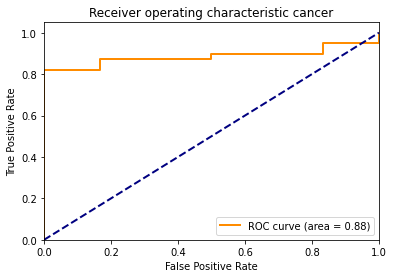

In [15]:
val_every = 5
train_losses = []
train_accs = []
val_losses = []
val_accs = []
sensitivities = []
specifiities = []
fdrs = []
train()

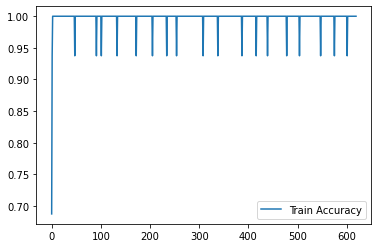

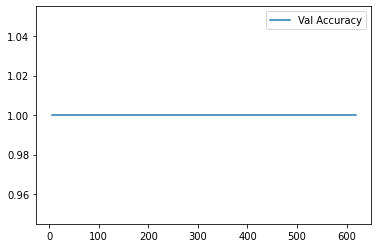

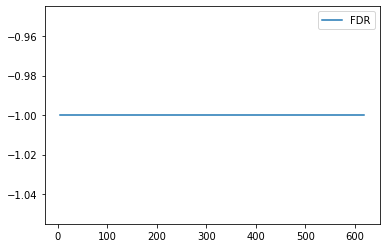

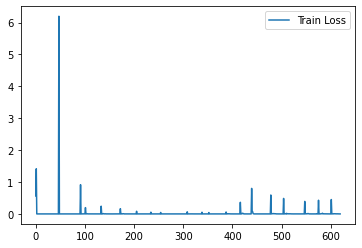

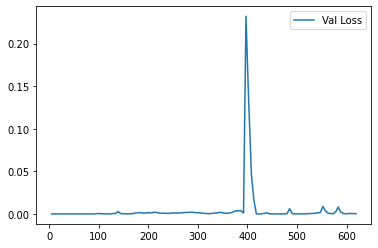

In [17]:
# plt.subplot(121)
plt.plot(np.arange(len(train_accs)), train_accs, label='Train Accuracy')
plt.legend()
plt.show() 
x, val = zip(*val_accs)
plt.plot(x, val, label='Val Accuracy') 
plt.legend()
plt.show() 
# x, val = zip(*sensitivities)
# plt.plot(x, val, label='Sensitivity')  
# plt.legend()
# plt.show() 
# x, val = zip(*specifiities)
# plt.plot(x, val, label='Specificity') 
# plt.legend()
# plt.show()   
x, val_loss = zip(*fdrs)
plt.plot(x, val_loss, label='FDR')
plt.legend()
plt.show() 
# plt.subplot(122)
plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
plt.legend()
plt.show() 
x, val_loss = zip(*val_losses)
plt.plot(x, val_loss, label='Val Loss')
plt.legend()
plt.show()  
